# Implementation Convolutional Bayesian Denoising Autoencoder Alzheimer MRI Scan Dataset


## Data loading and processing

In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
def plot_mnist_images(mnist_dataset):
    # Prepare to plot 2 rows of 5 images
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.flatten()

    # Plot MNIST images
    for i in range(10):  # First 2 rows (MNIST)
        image, label = mnist_dataset[i]
        image = image.squeeze().numpy()  # Convert tensor to numpy array and remove single-dimensional entries
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Adjust vertical and horizontal space
    plt.tight_layout()
    plt.show()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5455057.69it/s] 


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 158644.07it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 906254.68it/s] 


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3709215.10it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



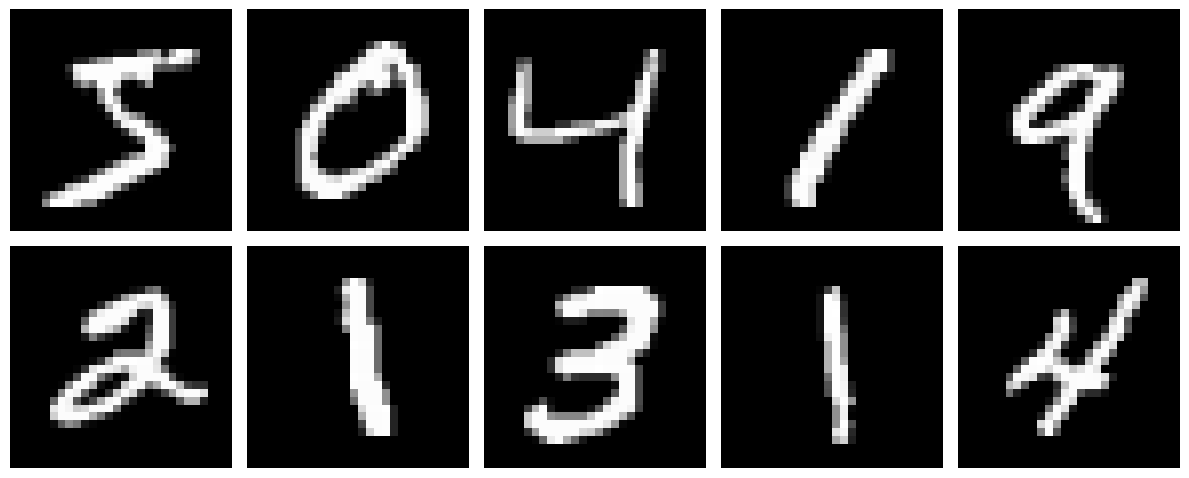

In [5]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

mnist_dataset = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True, download=True, transform=transform)

# Call the function with the datasets
plot_mnist_images(mnist_dataset)

100%|██████████| 561753746/561753746 [00:25<00:00, 22232400.61it/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


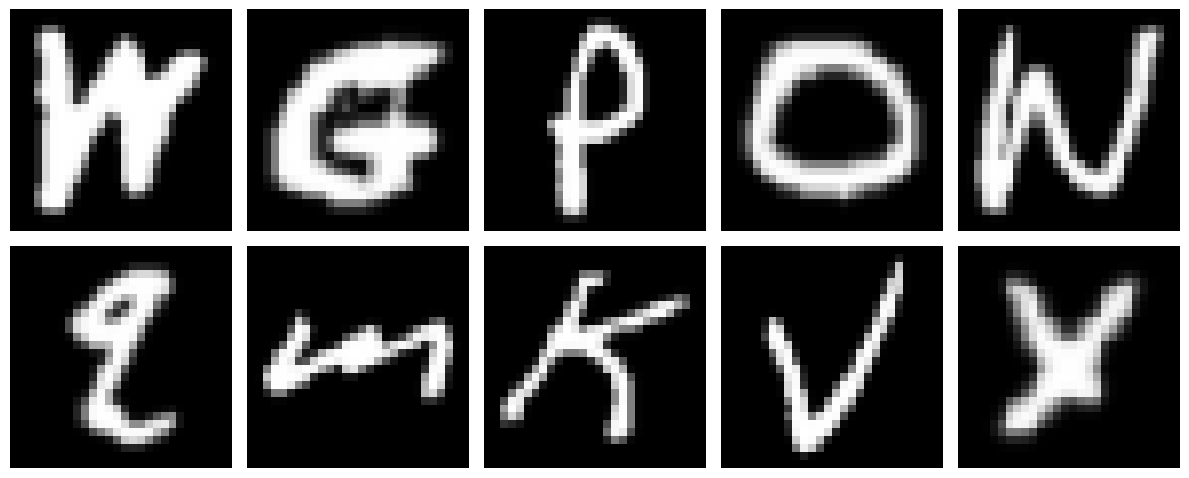

In [6]:
# Load the EMNIST dataset
emnist_dataset = datasets.EMNIST(
    root='./data',
    download=True,
    split='letters',
    train=True,
    transform=transforms.Compose([
        lambda img: transforms.functional.rotate(img, -90),
        lambda img: transforms.functional.hflip(img),
        transforms.ToTensor()
    ])
)

plot_mnist_images(emnist_dataset)

In [11]:
# Constants
image_size = 128
dataset_path = '/content/drive/MyDrive/mri_dataset'
batch_size = 64

# Custom Dataset Class
class MRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith(('.jpeg', '.jpg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L').resize((image_size, image_size))
        if self.transform:
            image = self.transform(image)
        return image, 0  # Dummy label

# Create dataset instance
mri_dataset = MRIDataset(root_dir=dataset_path, transform=transform)

In [8]:
def plot_dataset(dataset, num_images=18):
    # Prepare to plot 2 rows of 9 images
    fig, axes = plt.subplots(2, 9, figsize=(17, 4))  # Adjust the figsize as needed
    for i, ax in enumerate(axes.flatten()):
        if i < num_images:  # Ensure we don't go out of the dataset bounds
            image, _ = dataset[i]
            ax.imshow(image.squeeze(), cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')  # Turn off axes for any extra subplots
    plt.tight_layout()
    plt.show()

100%|██████████| 26421880/26421880 [00:08<00:00, 3248120.07it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 68161.03it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2582252.79it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5927059.29it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



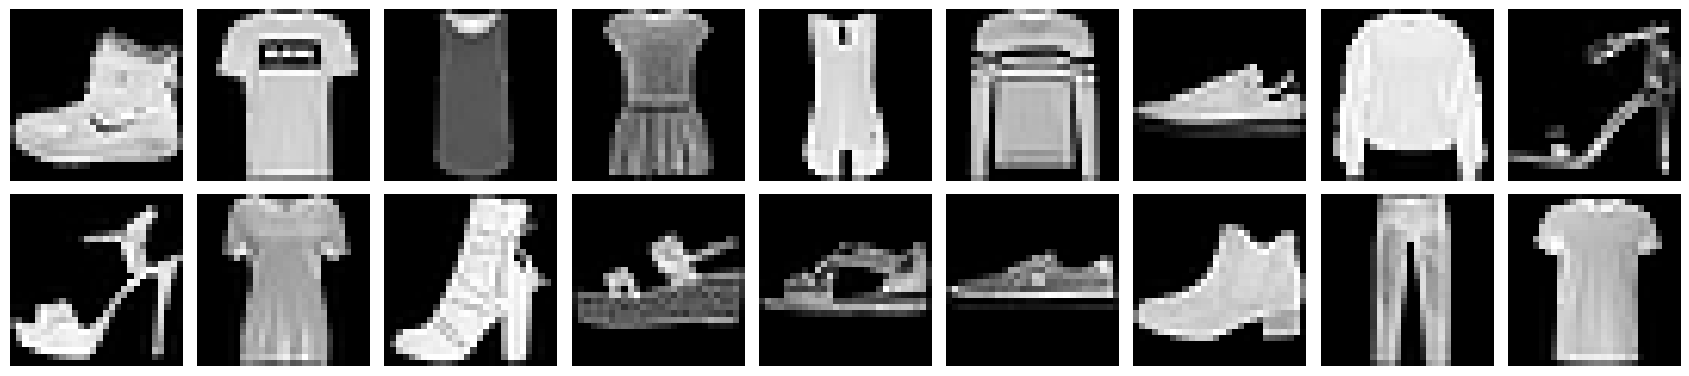

In [9]:
# load the training and test datasets
fashion_dataset = datasets.FashionMNIST(root='data', train=True,
                                      download=True, transform=transform)

plot_dataset(fashion_dataset)

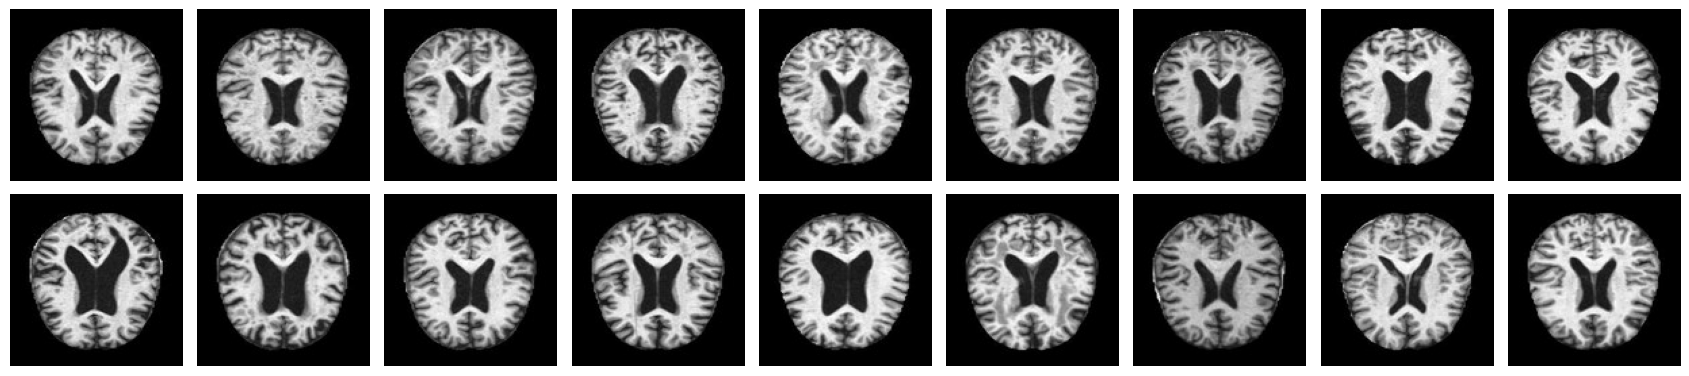

In [12]:
plot_dataset(mri_dataset)

In [13]:
def add_gaussian_noise(images, noise_factor=0.5):
  corrupted_images = images + noise_factor * torch.randn(*images.shape)
  corrupted_images = np.clip(corrupted_images, 0., 1.)
  return corrupted_images

In [17]:
def get_image_row(dataset, start_index, num_images=3):
    images = []
    for i in range(num_images):
        image, _ = dataset[start_index + i]
        images.append(image)
    return images

# Assuming you want to plot the first row of images
start_index_mnist = 0
start_index_fashion = 0
start_index_xray = 0

mnist_images = get_image_row(mnist_dataset, start_index_mnist)
fashion_images = get_image_row(fashion_dataset, start_index_fashion)
xray_images = get_image_row(mri_dataset, start_index_xray)

In [18]:
def plot_row(mnist_images, fashion_images, xray_images, noise_factor):
    plt.figure(figsize=(17, 4))  # Set the figure size to match the desired layout

    total_columns = 9  # Total number of columns

    # Function to plot a single image with Gaussian noise
    def plot_image_with_noise(image, index, total_columns, image_size):
        noisy_image = add_gaussian_noise(image.view(1, *image_size), noise_factor)
        ax = plt.subplot(2, total_columns, index + 1)  # Adjusted to handle two rows
        ax.imshow(noisy_image.view(*image_size), cmap='gray')
        ax.axis('off')

    # Plot first row
    for i in range(3):
        plot_image_with_noise(mnist_images[i], i, total_columns, (28, 28))

    for i in range(3):
        plot_image_with_noise(fashion_images[i], i + 3, total_columns, (28, 28))

    for i in range(3):
        plot_image_with_noise(xray_images[i], i + 6, total_columns, (128, 128))

    plt.tight_layout(pad=1)  # Adjust the padding between plots
    plt.show()

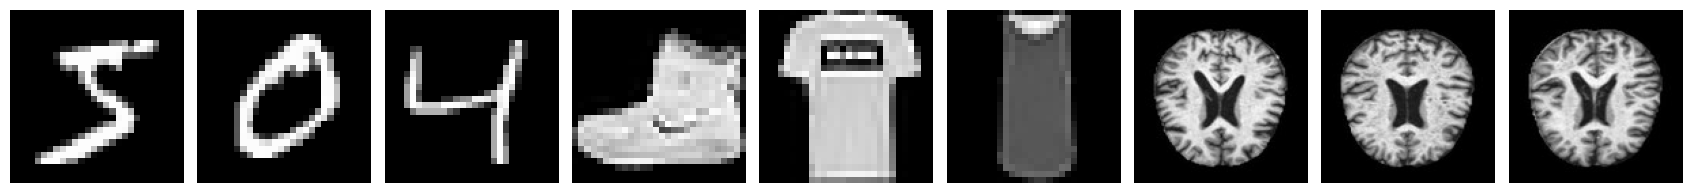

In [19]:
plot_row(mnist_images, fashion_images, xray_images, 0)

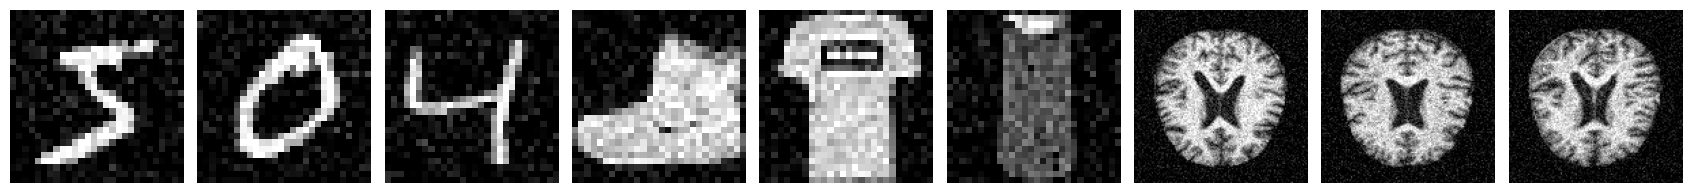

In [20]:

plot_row(mnist_images, fashion_images, xray_images, 0.1)

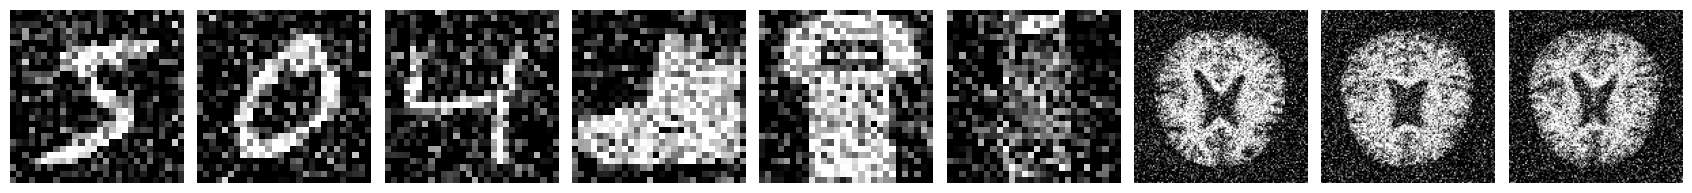

In [21]:
plot_row(mnist_images, fashion_images, xray_images, 0.3)

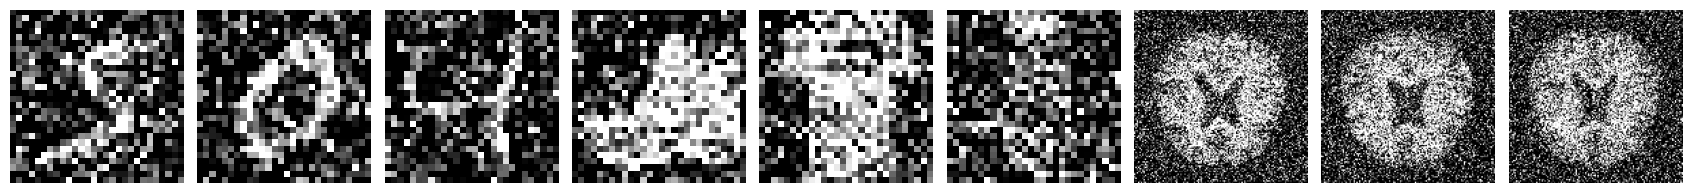

In [22]:
plot_row(mnist_images, fashion_images, xray_images, 0.5)